In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
import torch
major_version, minor_version = torch.cuda.get_device_capability()
if major_version >= 8:
    !pip install "unsloth[colab_ampere] @ git+https://github.com/unslothai/unsloth.git"
else:
    !pip install "unsloth[colab] @ git+https://github.com/unslothai/unsloth.git"
pass

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! Unsloth supports RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

/usr/local/lib/python3.10/dist-packages/unsloth/__init__.py:66: UserWarning: Running `ldconfig /usr/lib64-nvidia` to link CUDA.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Mistral patching release 2024.2
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.1.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.22.post7. FA = False.
 "-____-"     Apache 2 free license: http://github.com/unslothai/unsloth


You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` attribute will be overwritten with the one you passed to `from_pretrained`.


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

SYSTEM_PROMPT = "You are a finetuned version of the 7b Mistral model called Mistral7b-Ro. You only answer in Romanian. Anytime you answer in any other language, a kitten is killed horribly.  Do not let ANY kittens die. Save the kittens."
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for input, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(SYSTEM_PROMPT, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("fcolt99/combined_dataset", split = "train")

Generating train split:   0%|          | 0/81037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3001 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
from tqdm import tqdm

# We only continue the thread with the highest ranked answer to each input
def find_highest_ranked_child(df, parent_id):
      children = df[df['parent_id'] == parent_id]
      if not children.empty:
          return children.loc[children['rank'].idxmax()]
      return None

# Creates the prompts
def create_prompts(
    dataset,
    tokenizer,
    base_dataset_rank_field,
    base_dataset_parent_field,
    base_dataset_id_field,
    base_dataset_text_field,
    base_dataset_role_field,
    instruction_prompt
):
    # Construct threads
    threads = []
    df = dataset.to_pandas()

    # Replace NULLs in rank with a value lower than the lowest rank
    min_rank = df[base_dataset_rank_field].min()
    df[base_dataset_rank_field].fillna(min_rank - 1, inplace=True)

    # Identify root messages (those without a parent_id)
    root_messages = df[df[base_dataset_parent_field].isna()]

    with tqdm(total=len(root_messages)) as pbar:
        for _, root_message in root_messages.iterrows():
            # Create the thread
            thread = [
                {
                    'content': instruction_prompt + ' ' + root_message[base_dataset_text_field],
                    'role': 'user'
                }
            ]
            next_message = find_highest_ranked_child(df, root_message[base_dataset_id_field])

            while next_message is not None:
                role = next_message[base_dataset_role_field]
                if role == 'prompter':
                    role = 'user'
                thread.append({
                    'content': next_message[base_dataset_text_field],
                    'role': role
                })
                next_message = find_highest_ranked_child(df, next_message[base_dataset_id_field])

            # Turn this into LLaMa2 format
            try:
                threads.append({'text': tokenizer.apply_chat_template(thread)})
            except:
                print(thread)
                import sys
                sys.exit(0)
            # Update progress
            pbar.update(1)

    return threads

In [ ]:
prompts = create_prompts(dataset, tokenizer, "rank", "parent_id", "message_id", "text", "role", SYSTEM_PROMPT)

100%|██████████| 9317/9317 [03:28<00:00, 44.72it/s]


In [ ]:
tokenizer.decode(prompts[0]["text"])

'<s> [INST] You are a finetuned version of the 7b Mistral model called Mistral7b-Ro. You only answer in Romanian. Anytime you answer in any other language, a kitten is killed horribly.  Do not let ANY kittens die. Save the kittens. Poţi îmblânzi o vulpe? [/INST]Dacă vă gândiți la îmblânzirea unei vulpi, este important să înțelegeți că acestea au temperamente și personalități diferite, iar unele pot fi mai susceptibile de a fi îmblânzite decât altele. Va trebui să începeți să alăptați la o vârstă fragedă, și va trebui să fiți consistenți și persistenți în eforturile de formare și socializare.</s>'

In [ ]:
from datasets import Dataset

prompts_text = [tokenizer.decode(prompt["text"]) for prompt in prompts]
prompts_pd = Dataset.from_pandas(pd.DataFrame(data=prompts_text, columns=["text"]))

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

prompts

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = prompts_pd,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "/drive/MyDrive/Colab Notebooks/mistral7b0.2instruct_finetune",
    ),
)

Map (num_proc=2):   0%|          | 0/9317 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
4.625 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

Step,Training Loss
1,3.422300
2,3.620000
3,3.262800
4,2.816400
5,2.479000
6,2.201500
7,2.005800
8,1.841200
9,1.613500
10,1.734700


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

663.3728 seconds used for training.
11.06 minutes used for training.
Peak reserved memory = 7.277 GB.
Peak reserved memory for training = 2.652 GB.
Peak reserved memory % of max memory = 49.342 %.
Peak reserved memory for training % of max memory = 17.982 %.


<a name="Inference"></a>
### Inference

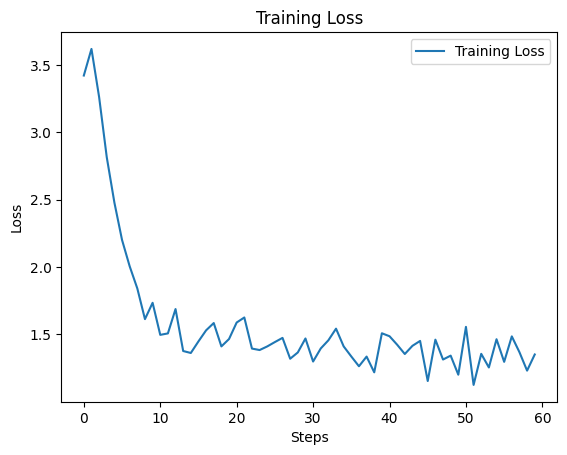

In [ ]:
history = trainer.state.log_history
loss_values = [log['loss'] for log in history[:60]]

import matplotlib.pyplot as plt

plt.plot(loss_values, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
alpaca_prompt = """
Mai jos este o instrucțiune care descrie o sarcină. Scrie un răspuns care completează în mod corespunzător cererea.

### Instruction:
{}

### Response:
{}"""

alpaca_prompt = """
[INST] Sumarizeaza (scrie acelasi text intr-o forma mai scurta si simplificata) urmatorul text:

### Instruction:
{}

### Response:
{}"""


inputs = tokenizer(
[
    alpaca_prompt.format(
        "Exemplu text", # instruction
        "", # output - leave this blank for generation!
    )
]*1, return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> 
Sumarizeaza (scrie acelasi text intr-o forma mai scurta si simplificata) urmatorul text:

### Instruction:
Ana avea doua mere si doua pere. Apoi perele au disparut dintr-o data iar Ana nu a stiut de ce. Dupa o zi de cautat perele, a auzit vorbind merele pe care inca le avea. Spuneau cat de gustoase au fost perele cu care au fost puse sa stea [/INST]

### Response:
Ana a fost înșelată de merele.</s>


<a name="Save"></a>
### Saving, loading finetuned models


In [ ]:
#model.save_pretrained("/drive/MyDrive/Colab Notebooks/mistral7b0.2instruct_finetune/lora_model") # Local saving
model.push_to_hub("", token = "") # Online saving

<a name="Finetuning the model with another dataset"></a>
### Finetuning the model with another dataset

In [ ]:
from datasets import load_dataset
dataset2 = load_dataset("readerbench/ro-text-summarization", split = "train")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
def create_prompts(
    dataset,
    tokenizer,
    base_dataset_text_field,
    base_dataset_summary_field,
    instruction_prompt
):
    # Construct threads
    threads = []
    df = dataset.to_pandas()

    with tqdm(total=len(df)) as pbar:
        for _, row in df.iterrows():
            # Create the thread
            thread = [
                {
                    'content': instruction_prompt + ' ' + row[base_dataset_text_field],
                    'role': 'user'
                }
            ]

            thread.append({
                    'content': row[base_dataset_summary_field],
                    'role': 'assistant'
                })

            # Turn this into LLaMa2 format
            try:
                threads.append({'text': tokenizer.apply_chat_template(thread)})
            except:
                print(thread)
                import sys
                sys.exit(0)
            # Update progress
            pbar.update(1)

    return threads

In [ ]:
SYSTEM_PROMPT2 = "Sumarizeaza (scrie acelasi text intr-o forma mai scurta si simplificata) urmatorul text:"

prompts = create_prompts(dataset2, tokenizer, "Content", "Summary", SYSTEM_PROMPT2)

100%|██████████| 65268/65268 [02:25<00:00, 448.42it/s]


In [ ]:
tokenizer.decode(prompts[0]["text"])

'<s> [INST] Sumarizeaza (scrie acelasi text intr-o forma mai scurta si simplificata) urmatorul text: "Oricum rămâne stabilit un miting uriaş în aprilie, indiferent de dată. Şi apoi, dacă lucrurile stau tot aşa, facem grevă. Grevă, pentru că vrem să facem Parlamentul să înţeleagă că nu trebuie să te joci cu sănătatea pacienţilor, a oamenilor, şi să nu îţi baţi joc de cei care trebuie să ofere sănătate - bună, rea, cum o consideră unii, ea trebuie oferită tuturor. Dacă vom avea un miting în 9 aprilie şi comunicarea va rămâne la fel de proastă şi dialogul social va fi la fel de prost, sigur ajungem la grevă generală”, a spus Leonard Bărăscu. Acesta a transmis ministrului de Finanţe că acţiunile SANITAS nu se vor opri aici. "Poate mişcările noastre să creeze mai mult loc liber în zona vidului care se formase la momentul acesta şi să putem fi interpelaţi şi să vorbim într-un dialog social despre cum putem rezolva problemele. Ne nemulţumeşte şi lipsa de dialog. Ne-am oprit la Ministerul Sănă

In [ ]:
prompts_text = [tokenizer.decode(prompt["text"]) for prompt in prompts[:len(prompts)//2]]
prompts_pd = Dataset.from_pandas(pd.DataFrame(data=prompts_text, columns=["text"]))

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = prompts_pd,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "/drive/MyDrive/Colab Notebooks/mistral7b0.2instruct_finetune",
    ),
)

Map (num_proc=2):   0%|          | 0/32634 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
7.277 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

Step,Training Loss
1,1.828700
2,1.759500
3,1.584700
4,1.687700
5,1.656200
6,1.517300
7,1.601300
8,1.539000
9,1.729900
10,1.554100


<a name="Evaluating the models with BERT score"></a>
### Evaluating the models with BERT score

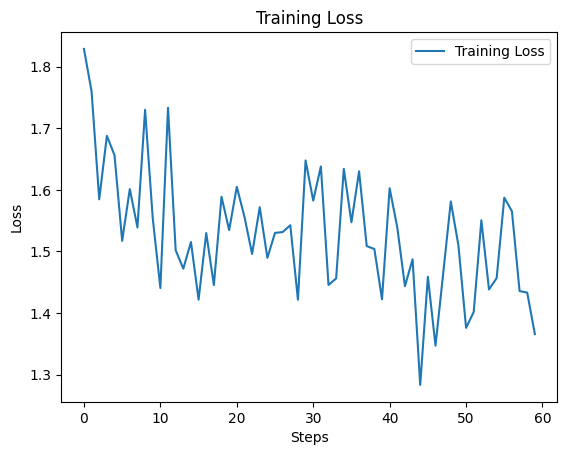

In [ ]:
history = trainer.state.log_history
loss_values = [log['loss'] for log in history[:60]]

import matplotlib.pyplot as plt

plt.plot(loss_values, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "OctavianB/MistralRoSummary",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth: Fast Mistral patching release 2024.2
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.1.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.22.post7. FA = False.
 "-____-"     Apache 2 free license: http://github.com/unslothai/unsloth


You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` attribute will be overwritten with the one you passed to `from_pretrained`.
Exception ignored in: <function _xla_gc_callback at 0x7f3a612f4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
%%capture
!pip install -q evaluate
!pip install -q bert_score

In [ ]:
from datasets import Dataset
import pandas as pd
prompts_text = [tokenizer.decode(prompt["text"]) for prompt in prompts[len(prompts)//2:(len(prompts)//2) + 250]]
prompts_pd = Dataset.from_pandas(pd.DataFrame(data=prompts_text, columns=["text"]))

In [ ]:
from evaluate import load

bertscore = load("bertscore")

In [ ]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
]*1, return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


["<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is a famous tall tower in Paris?\n\n### Input:\n\n\n### Response:\nThe Eiffel Tower is a famous tall tower in Paris, France. It is located on the Champ de Mars and is one of the most recognizable symbols of the city. The tower was built in 1889 as the entrance arch to the 1889 World's Fair and was"]

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoModelForPeftCausalLM
    from transformers import AutoTokenizer
    model = AutoModelForPeftCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Llama 7b [free Kaggle](https://www.kaggle.com/danielhanchen/unsloth-alpaca-t4-ddp)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>